In [1]:
import sys
sys.path.append('../code/')

import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm
import pickle

from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import CoxPHFitter

from utils import round_pval

import seaborn as sns

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['hatch.linewidth'] = 5.0 

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = 'Arial'

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
# load data
from meningioma_utils import load_reference_umap
umap_df = load_reference_umap()
umap_df['umap_2'] = -umap_df['umap_2']

cluster_df = pd.read_csv('../data/dbscan_clusterID.csv', index_col=0)

metadata_df = pd.read_csv('../data/patient_clinical_metadata.csv', index_col=0)

# Load CV results from Figure 7

In [3]:
score_df = pd.read_csv('../data/pipeline_cv_results.csv', index_col=0)

SCORE_DF = score_df.loc[(score_df['init_nn_score'] < 0.75)]
centroid_df = SCORE_DF[['x_cent', 'y_cent']]

# Sup Figure 7B

In [4]:
na_all_idxs = cluster_df.loc[cluster_df['cluster'] == '0'].index.tolist()
na_20_idxs = cluster_df.loc[cluster_df['cluster'].isin(['0', 'G', 'H', 'I'])].index.tolist()
    
na_dict = {'All':na_all_idxs, '>20':na_20_idxs}

weight_list = [5,10,15]

preds_dict = {}
for cluster_set in ['All', '>20']:
    na_idxs = na_dict[cluster_set]
    preds_dict[cluster_set] = {}

    vc_df_list = []

    for patient in tqdm(centroid_df.index):
        x_cent, y_cent = centroid_df.loc[patient]['x_cent'], centroid_df.loc[patient]['y_cent']

        values = np.sum((umap_df - np.array([x_cent, y_cent]))**2, axis=1)
        dist_df = pd.DataFrame(data=values, 
                               index=umap_df.index, 
                               columns=['dist']).drop(index=[patient]).sort_values('dist')
        dist_df = dist_df.loc[~dist_df.index.isin(na_idxs)]

        _vc_df_list = []
        for num_nn in weight_list:
            nns_idxs = dist_df.index.tolist()[:num_nn]
            vc_df = cluster_df.loc[nns_idxs]['cluster'].value_counts()
            vc_df.name = patient
            _vc_df_list.append(vc_df)

        vc_merged_df = pd.concat(_vc_df_list)
        vc_merged_df = vc_merged_df.groupby(vc_merged_df.index).sum()
        vc_df_list.append(vc_merged_df)

    probs = pd.concat(vc_df_list, axis=1).replace({np.nan:0})/30
    preds = probs.idxmax(axis=0)

    preds_dict[cluster_set]['probs'] = probs
    preds_dict[cluster_set]['preds'] = preds    

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

In [5]:
from sklearn.metrics import precision_score, recall_score
from utils import get_avg_mcc, get_avg_auc, get_avg_acc

cluster_set = 'All'

result_dict = {}
for cluster_set in ['All', '>20']:

    na_idxs = na_dict[cluster_set]
    
    y_true = cluster_df.loc[(cluster_df.index.isin(centroid_df.index)) & (~cluster_df.index.isin(na_idxs))]['cluster']
    y_pred = preds_dict[cluster_set]['preds'].loc[y_true.index]
    y_probs = preds_dict[cluster_set]['probs'][y_true.index.tolist()]
    print(len(y_true), len(y_pred), y_probs.shape)

    precision_micro = precision_score(y_true=y_true, y_pred=y_pred, average='micro')
    recall_micro = recall_score(y_true=y_true, y_pred=y_pred, average='micro')
    bal_acc_micro = get_avg_acc(y_true=y_true, y_preds=y_pred)['micro']
    mcc_micro = get_avg_mcc(y_true=y_true, y_preds=y_pred, y_probs=y_probs.T)['micro']
    auc_micro = get_avg_auc(y_true, y_probs.T.loc[y_true.index])['micro']
    
    precision_mac = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_mac = recall_score(y_true=y_true, y_pred=y_pred, average='macro')
    bal_acc_mac = get_avg_acc(y_true=y_true, y_preds=y_pred)['macro']
    mcc_mac = get_avg_mcc(y_true=y_true, y_preds=y_pred, y_probs=y_probs.T)['macro']
    auc_mac = get_avg_auc(y_true, y_probs.T.loc[y_true.index])['macro']

    result_dict['micro' + '_' + cluster_set] = {'precision':precision_micro, 'recall':recall_micro, 
                                                'bal_acc':bal_acc_micro, 'mcc':mcc_micro, 'auc':auc_micro}
    
    result_dict['macro' + '_' + cluster_set] = {'precision':precision_mac, 'recall':recall_mac, 
                                                'bal_acc':bal_acc_mac, 'mcc':mcc_mac, 'auc':auc_mac}

results_df = pd.DataFrame.from_dict(data=result_dict, orient='index')
results_df

1209 1209 (7, 1209)
1197 1197 (6, 1197)


/Users/nuechterleinnk/Documents/repos/MeningiomaLandscape-HollandLab/notebooks/../code/utils.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_y_true = y_true.replace(replace_dict)
/Users/nuechterleinnk/Documents/repos/MeningiomaLandscape-HollandLab/notebooks/../code/utils.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_y_preds = y_preds.replace(replace_dict)
/Users/nuechterleinnk/Documents/repos/MeningiomaLandscape-HollandLab/notebooks/../code/utils.py:78: FutureWarning: Downcasting behavior in `replace` is depr

,precision,recall,bal_acc,mcc,auc
micro_All,0.978495,0.978495,0.978495,0.970064,0.987297
macro_All,0.985845,0.976269,0.976269,0.976612,0.986911
micro_>20,0.979114,0.979114,0.979114,0.970740,0.987786
macro_>20,0.983858,0.986203,0.986203,0.980105,0.991769


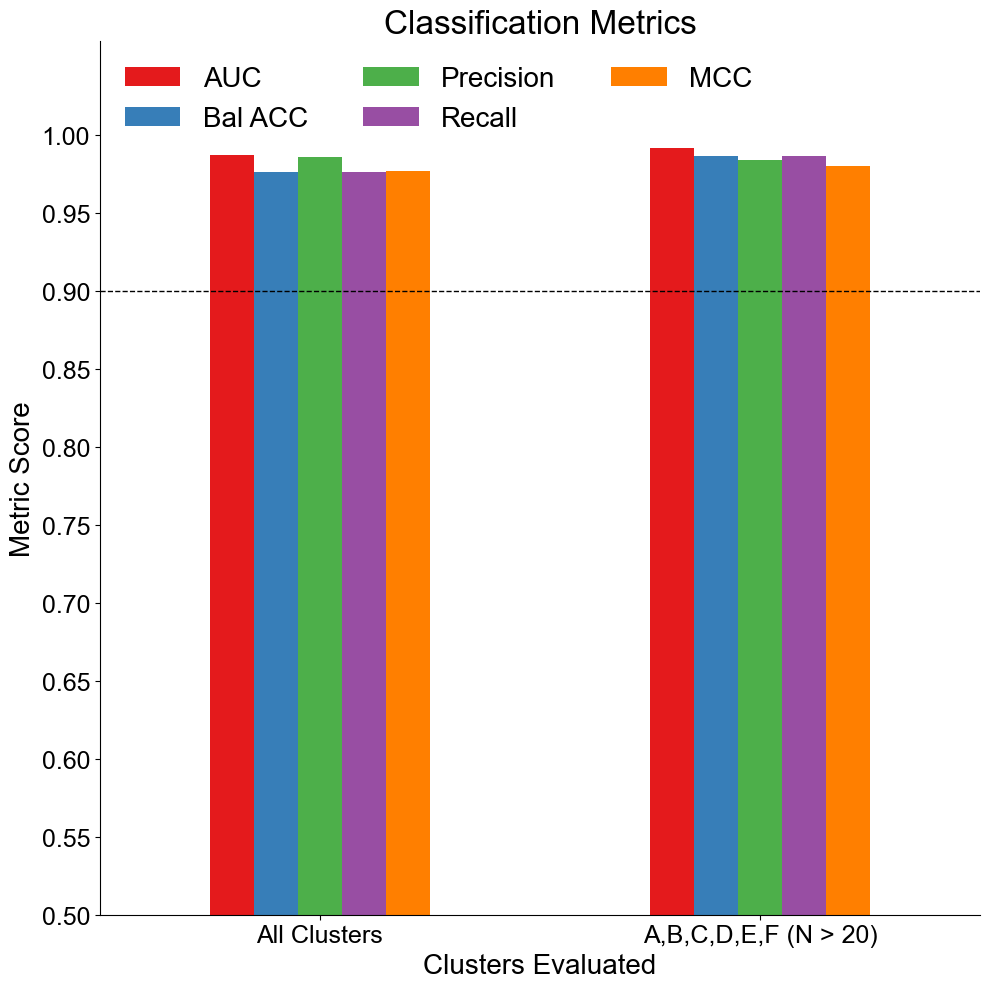

In [6]:
cols = ['auc', 'bal_acc', 'precision', 'recall', 'mcc']
rename_col_dict = {'auc':'AUC', 'bal_acc':'Bal ACC', 'precision':'Precision', 'recall':'Recall', 'mcc':'MCC'}
rename_index_dict = {'macro_All':'All Clusters', 'macro_>20':'A,B,C,D,E,F (N > 20)'}

color_list = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

fig, ax = plt.subplots(figsize=(10,10))

_results_df = results_df.loc[['macro_All', 'macro_>20']]
_results_df = _results_df[cols].rename(columns=rename_col_dict, index=rename_index_dict)
_results_df.plot.bar(rot=0, ax=ax, color=color_list)


ax.legend(frameon=False, fontsize=20, markerscale=3, ncol=3, loc='upper left')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 

ax.tick_params(labelsize=18)

ax.set_xlabel('Clusters Evaluated', fontsize=20)
ax.set_ylabel('Metric Score', fontsize=20)

ax.set_ylim(0.5, 1.06)

ax.axhline(y=0.9, c='k', lw=1, ls='--')

ax.set_title('Classification Metrics', fontsize=24)

plt.yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95,1])


plt.tight_layout()
# plt.savefig('../figures/nayanga/pdfs/SupFig7B.pdf', transparent=True, dpi=300)
plt.show()

# Sup Figure 7c

In [7]:
from sklearn.metrics import confusion_matrix

cluster_set = 'All'

na_idxs = na_dict[cluster_set]
y_true = cluster_df.loc[(cluster_df.index.isin(centroid_df.index)) & (~cluster_df.index.isin(na_idxs))]['cluster']
y_preds = preds_dict[cluster_set]['preds'].loc[y_true.index]

cm_mat = confusion_matrix(y_true=y_true, y_pred=y_preds)
cm_df = pd.DataFrame(data=cm_mat, 
                     index=y_true.unique(), 
                     columns=y_true.unique())
cm_df

,A,B,C,D,E,F,G
A,433,14,1,0,1,0,0
B,0,282,0,0,0,0,0
C,7,0,200,0,0,0,0
D,0,0,2,148,0,0,0
E,0,0,0,0,52,0,0
F,0,0,0,0,0,57,0
G,1,0,0,0,0,0,11


/Users/nuechterleinnk/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


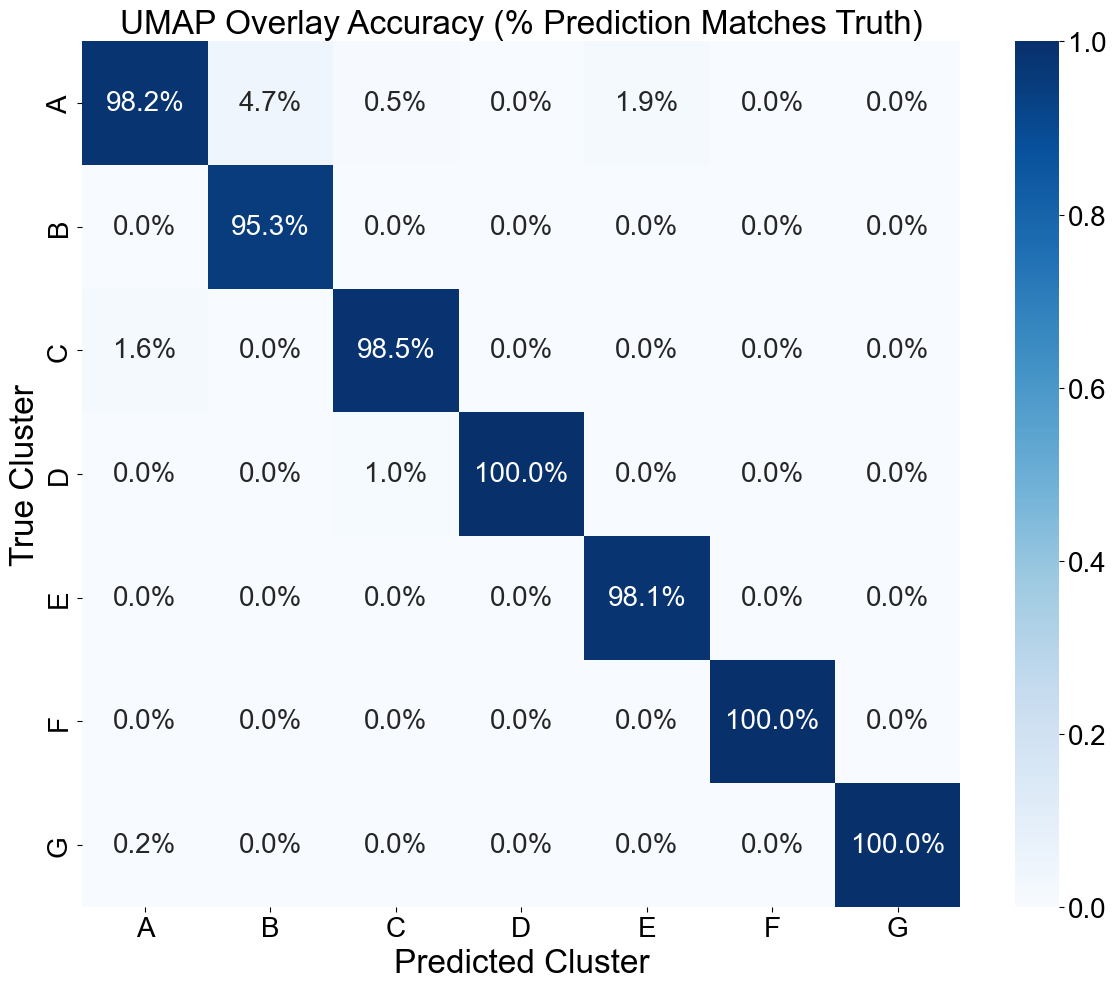

In [8]:
fig, ax = plt.subplots(figsize=(12,10))

ax_plot = sns.heatmap(cm_df/np.sum(cm_df), annot=True, fmt='.1%', cmap='Blues', annot_kws=dict(fontsize=20))

ax.set_ylabel('True Cluster', fontsize=24)
ax.set_xlabel('Predicted Cluster', fontsize=24)

ax.tick_params(labelsize=20)

cbar = ax_plot.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

ax.set_title('UMAP Overlay Accuracy (% Prediction Matches Truth)', fontsize=24)

plt.tight_layout()
plt.show()

# Sup Figure 7d

In [9]:
true_pred_df = pd.concat([y_true, y_preds], axis=1)
col1, col2 = true_pred_df.columns[0], true_pred_df.columns[1]

incorrect_idxs = true_pred_df.loc[true_pred_df[col1] != true_pred_df[col2]].index.tolist()
correct_idxs = true_pred_df.loc[true_pred_df[col1] == true_pred_df[col2]].index.tolist()

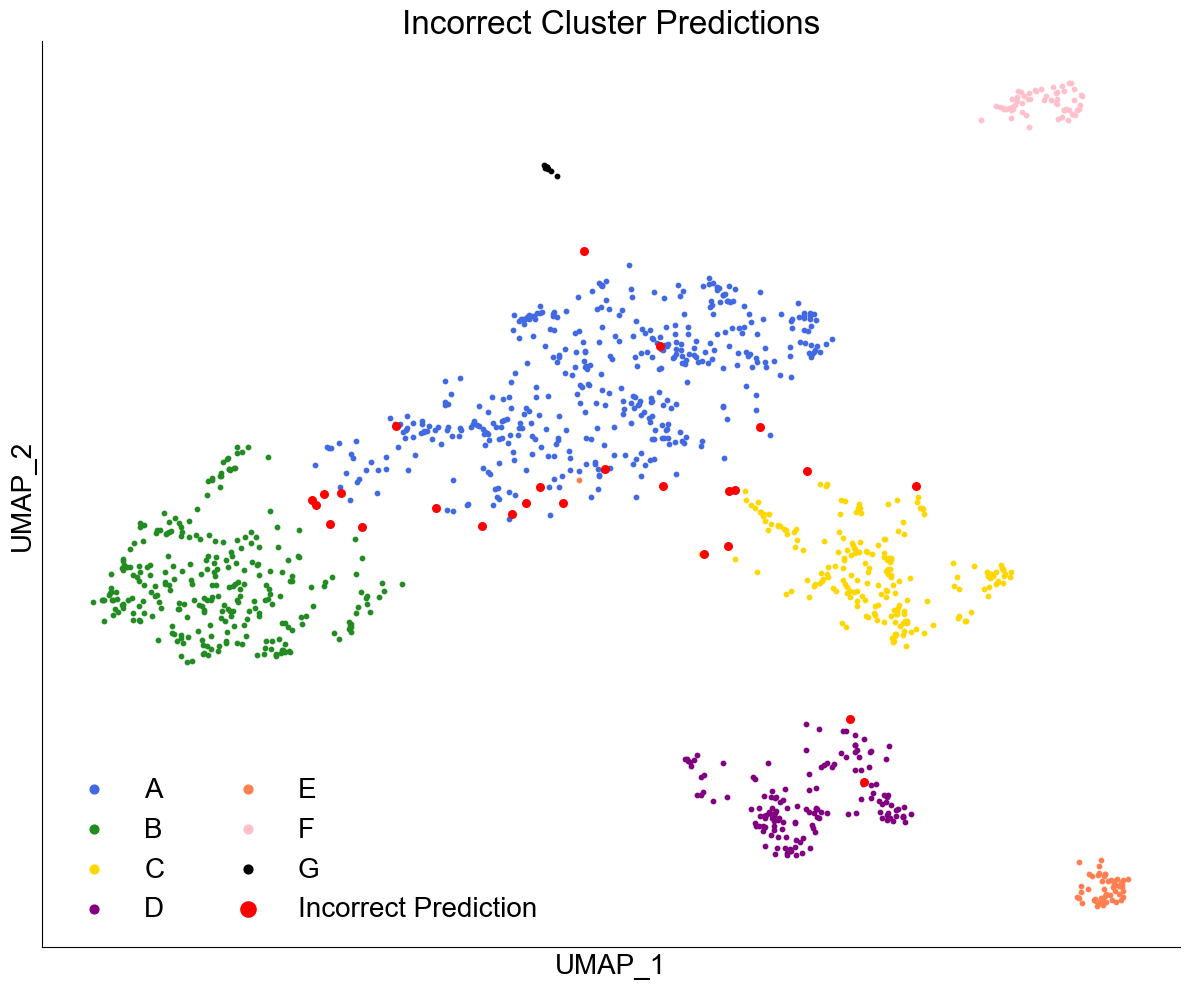

In [10]:
color_dict = {'A':'royalblue', 'B':'forestgreen', 'C':'gold', 'D':'purple', 'E':'coral', '0':'grey',
              'F':'pink', 'G':'black', 'H':'brown', 'I':'olive'}

fig, ax = plt.subplots(1,1,figsize=(12, 10))

_cluster_df = cluster_df.loc[correct_idxs]
for i, cluster in enumerate(_cluster_df['cluster'].unique()):
    cls_idxs = _cluster_df.loc[_cluster_df['cluster'] == cluster].index.tolist()
    ax.scatter(umap_df['umap_1'].loc[cls_idxs], umap_df['umap_2'].loc[cls_idxs], color=color_dict[cluster],
              label=cluster, s=10)
    
ax.scatter(umap_df['umap_1'].loc[incorrect_idxs], 
           umap_df['umap_2'].loc[incorrect_idxs], 
           color='red',
           label='Incorrect Prediction',
           s=30)

ax.legend(frameon=False, fontsize=20, markerscale=2, ncol=2)
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('UMAP_1', fontsize=20)
ax.set_ylabel('UMAP_2', fontsize=20)

ax.set_title('Incorrect Cluster Predictions', fontsize=24)

plt.tight_layout()
plt.show()

# Sup Figure 7e

In [11]:
grade_radius = 1
metadata_col = 'WHO_GRADE'

weight_list = [40]

vc_df_list = []
na_idxs = metadata_df.loc[metadata_df[metadata_col] == 'na'].index.tolist()

for patient in tqdm(SCORE_DF.index):
    x_cent, y_cent = SCORE_DF.loc[patient]['x_cent'], SCORE_DF.loc[patient]['y_cent']
    
    values = np.sum((umap_df - np.array([x_cent, y_cent]))**2, axis=1)
    dist_df = pd.DataFrame(data=values, 
                           index=umap_df.index, 
                           columns=['dist']).drop(index=[patient]).sort_values('dist')
    dist_df = dist_df.loc[~dist_df.index.isin(na_idxs)]
    dist_df = dist_df.loc[dist_df['dist'] < grade_radius]
    
    _vc_df_list = []
    for num_nn in weight_list:
        
        nns_idxs = dist_df.index.tolist()[:num_nn]
        vc_df = metadata_df.loc[nns_idxs][metadata_col].value_counts()
        vc_df.name = patient
        _vc_df_list.append(vc_df)
        
    vc_merged_df = pd.concat(_vc_df_list)
    vc_merged_df = vc_merged_df.groupby(vc_merged_df.index).sum()
    vc_df_list.append(vc_merged_df)
    
grade_weight_df = pd.concat(vc_df_list, axis=1).replace({np.nan:0})/np.sum(weight_list)
who_grade_pred_df = grade_weight_df.idxmax(axis=0)

  0%|          | 0/1234 [00:00<?, ?it/s]

In [12]:
pred_gt_df = pd.concat([metadata_df['WHO_GRADE'], who_grade_pred_df], axis=1, join='inner')
pred_gt_df = pred_gt_df.rename(columns={'WHO_GRADE':'GT_WHO_Grade', 0:'Pred_WHO_Grade'})
pred_gt_df = pred_gt_df.loc[pred_gt_df['GT_WHO_Grade'] != 'na']
pred_gt_df = pred_gt_df.sort_values('GT_WHO_Grade')

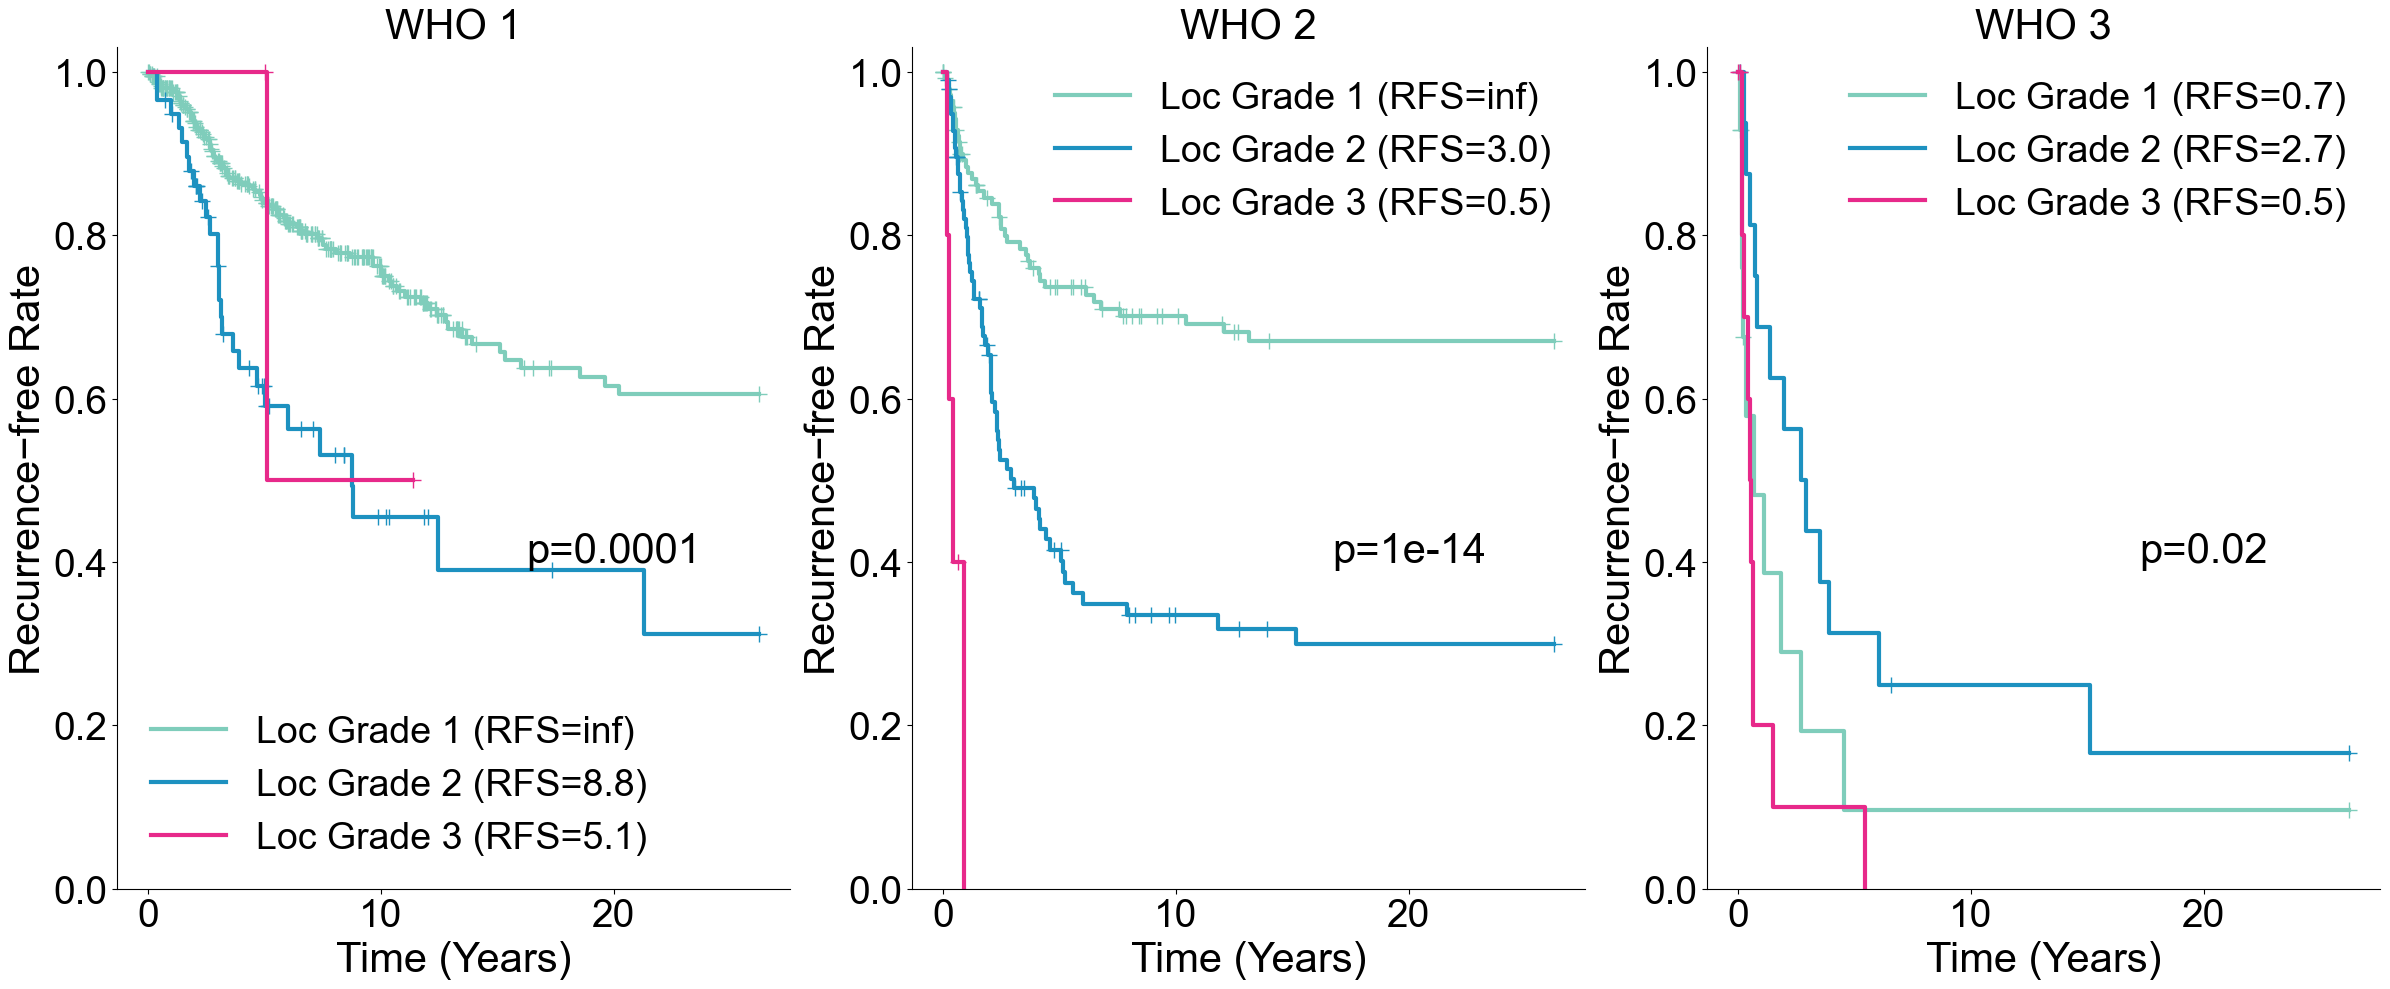

In [13]:
_label_df = (pred_gt_df['GT_WHO_Grade'] + ' -> ' + pred_gt_df['Pred_WHO_Grade']).to_frame(name='label')
kmf_df = pd.concat([metadata_df[['RFS', 'RFS_EVENT']], _label_df], axis=1, join='inner').dropna()

kmf_df['RFS_EVENT'] = kmf_df['RFS_EVENT'].astype(float)
kmf_df['RFS'] = kmf_df['RFS'].astype(float)
kmf_df['RFS'] = kmf_df['RFS']/12

replace_dict_dict = {'WHO I':{'WHO I':'1', 'WHO II':'2', 'WHO III':'3'},
                     'WHO II':{'WHO I':'1', 'WHO II':'2', 'WHO III':'3'},
                     'WHO III':{'WHO I':'1', 'WHO II':'2', 'WHO III':'3'}}

color_dict = {'WHO I':'#7fcdbb', 'WHO II':'#1d91c0', 'WHO III':'#e7298a',
             '1':'#7fcdbb', '2':'#1d91c0', '3':'#e7298a'}
rename_pred_grade_dict = {'WHO I':'Pred WHO I', 'WHO II':'Pred WHO II', 'WHO III':'Pred WHO III'}

idx = pred_gt_df.loc[pred_gt_df.index.isin(SCORE_DF.index)].index.tolist()


title_replace_dict = {'WHO I':'WHO 1', 'WHO II':'WHO 2', 'WHO III':'WHO 3'}


figsize = (24, 10)
fig, ax = plt.subplots(1,3,figsize=figsize)

for i, grade in enumerate(['WHO I', 'WHO II', 'WHO III']):
    
    
    grade_idx = pred_gt_df.loc[pred_gt_df['GT_WHO_Grade'] == grade].index.tolist()
    
    label_df = pred_gt_df['Pred_WHO_Grade'].loc[grade_idx].to_frame(name='label')
    kmf_temp_df = pd.concat([metadata_df[['RFS', 'RFS_EVENT']], label_df], axis=1, join='inner').dropna()
    kmf_temp_df['RFS'] = kmf_temp_df['RFS'].astype(float)/12
    kmf_temp_df['RFS_EVENT'] = kmf_temp_df['RFS_EVENT']
    kmf_temp_df = kmf_temp_df.loc[kmf_temp_df.index.isin(SCORE_DF.index)]
    
    kmf_temp_df = kmf_temp_df.replace(replace_dict_dict[grade])
    
    for label in kmf_temp_df['label'].sort_values().unique():

        kmf = KaplanMeierFitter()

        _kmf_df = kmf_temp_df.loc[kmf_temp_df['label'] == label]
        kmf.fit(_kmf_df['RFS'], _kmf_df['RFS_EVENT'], label=label)
        median_survival = np.round(kmf.median_survival_time_, 1)
        
        ax[i] = kmf.plot(ax=ax[i], 
                         figsize=figsize, 
                         fontsize=30, 
                         label='Loc Grade ' + label + ' (RFS=' + str(median_survival)+')', 
                         ci_show=False, 
                         color=color_dict[label], 
                         lw=3,
                         show_censors=True)
        
    results = multivariate_logrank_test(kmf_temp_df['RFS'].astype(float),  
                                        kmf_temp_df['label'], 
                                        kmf_temp_df['RFS_EVENT'].astype(float))
    p_value = round_pval(results.p_value)
    ax[i].text(x = 20, y=0.4, s='p='+str(p_value), fontsize=30, ha='center')
    
    ax[i].spines['right'].set_visible(False) 
    ax[i].spines['top'].set_visible(False) 

    ax[i].tick_params(labelsize=28)
    ax[i].set_xlabel('Time (Years)', fontsize=30)
    ax[i].set_ylabel('Recurrence−free Rate', fontsize=30)

    ax[i].legend(fontsize=27, frameon=False)
    ax[i].set_title(title_replace_dict[grade], fontsize=30)

    ax[i].set_ylim(0, 1.03)
    
    
plt.tight_layout()
plt.show()

# Sup Figure 7F

In [14]:
pred_gt_who12_df = pred_gt_df.loc[pred_gt_df['GT_WHO_Grade'].isin(['WHO I', 'WHO II'])]

forest_df = pd.concat([metadata_df[['RFS', 'RFS_EVENT']], pred_gt_who12_df], axis=1, join='inner').dropna()

replace_dict = {'WHO I':0, 'WHO II':1, 'WHO III':1}

forest_df = forest_df.replace(replace_dict)

/var/folders/bn/gp8lnmqn7h585rt7v2n467jnfnys2f/T/ipykernel_96734/348336814.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  forest_df = forest_df.replace(replace_dict)


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
WHO Grade\n(2),0.316493,1.372307,0.140201,0.041704,0.591282,1.042586,1.806303,0.0,2.257424,2.398158e-02,5.381930
Predicted\nWHO Grade\n(2 or 3),1.048698,2.853934,0.142283,0.769829,1.327568,2.159397,3.771858,0.0,7.370516,1.699687e-13,42.419796


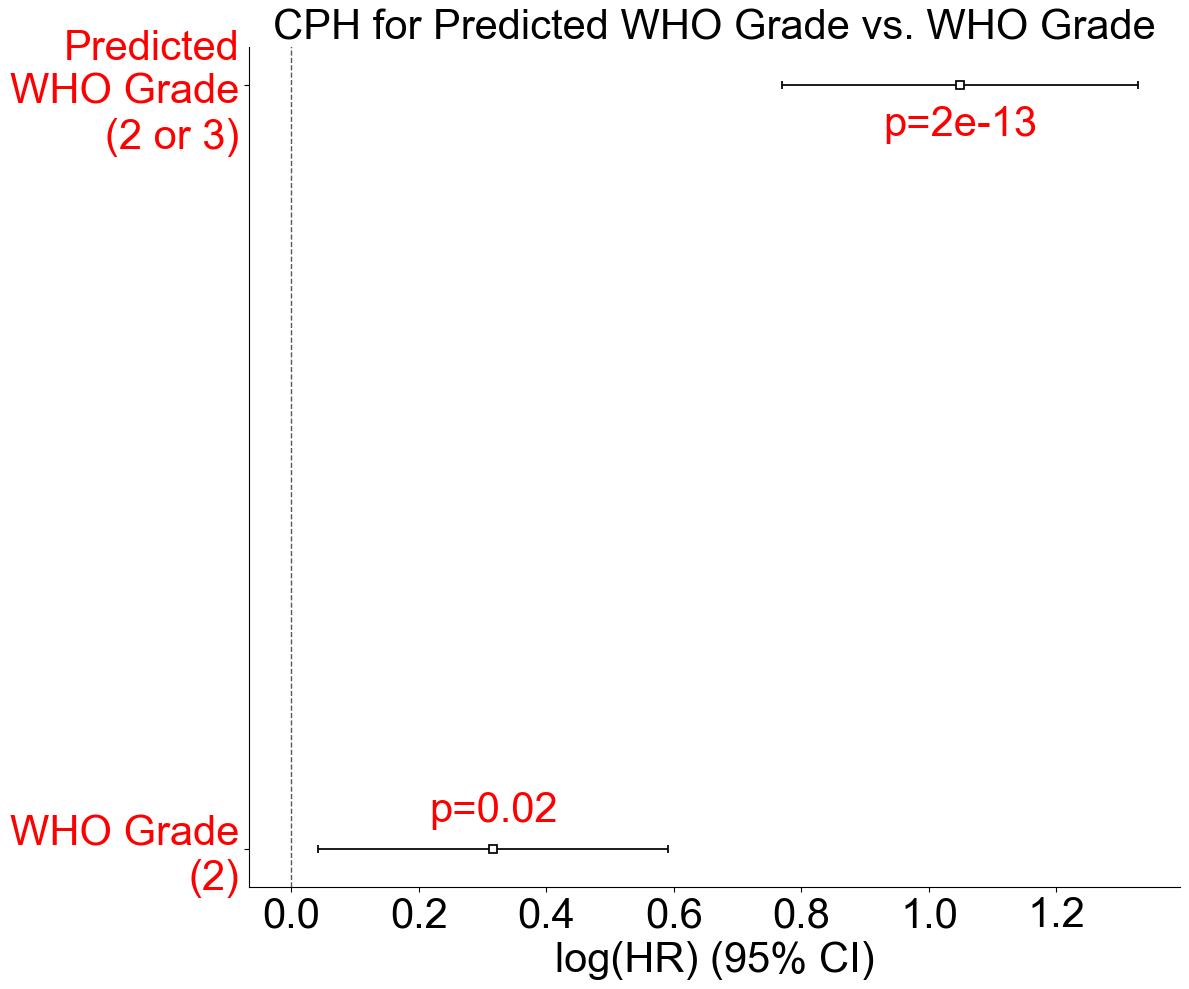

In [15]:
## Plot
title = 'CPH for Predicted WHO Grade vs. WHO Grade'

# dropping NAs
rename_dict = {'GT_WHO_Grade':'WHO Grade\n(2)', 'Pred_WHO_Grade':'Predicted\nWHO Grade\n(2 or 3)'}
plot_df = forest_df.dropna().rename(columns=rename_dict)

# fitting cox proportional hazard ratio model
cph = CoxPHFitter()
cph.fit(plot_df, duration_col='RFS', event_col='RFS_EVENT')

# plot
fig, ax = plt.subplots(figsize=(12,10))
cph.plot()

xlabel='log(HR) (95% CI)'
ylabel='Covariate'
ylabel = None
ax.set_title(title, fontsize=30)

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel(xlabel, fontsize=30)
plt.ylabel(ylabel, fontsize=30)

y_delta = -0.05
y0_delta = 0.05
pvalue_size=30

label_pvalues = True
if label_pvalues:
    _df = cph.summary.sort_values('coef')
    for i, idx in enumerate(_df.index):
        if i == 0:
            y = i + y0_delta
        else:
            y = i + y_delta
        x = _df.loc[idx]['coef']
        p_value = round_pval(_df.loc[idx]['p'])
        
        color = 'black'
        if p_value < 0.05:
            plt.text(x = x, y=y, s='p='+str(p_value), color='red', fontsize=pvalue_size, ha='center', va='center')
            ax.get_yticklabels()[i].set_color("red")
        else:
            plt.text(x = x, y=y, s='p='+str(p_value), color='black', fontsize=pvalue_size, ha='center', va='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
cph.summary